In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from YeoJohnson import YeoJohnson

from yellowbrick.regressor import ResidualsPlot
from scipy import stats
from sklearn.preprocessing import PowerTransformer

import warnings
#warnings.filterwarnings('ignore')

C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [168]:
# Read in the wrangled data
pepsico_data = pd.read_excel('wrangled-pepsico-data.xlsx')
pepsico_data.head()

,ID,Site ID,Growth Stage,Variety,Assessment Date (mm/dd/year),Assessment Type,Assessment Score,Sowing Date,Latitude,Elevation,Soil Param A,Soil Param B,Amount Fertilizer Applied,Avg Weather A,Avg Weather B,Avg Weather C,Avg Weather D,Avg Weather E,Avg Weather F
0,1,Site E 2015,59,M,2015-06-24,C - K,6.200000,2014-09-22,51.184087,77.0,5,9.6,125.0,11.548634,4.314840,1.996153,8.976947,15.595243,84.747701
1,2,Site E 2015,75,M,2015-07-10,C - G,2.972832,2014-09-22,51.184087,77.0,5,9.6,125.0,12.143576,4.735432,1.987727,9.614748,15.397119,84.305256
2,3,Site E 2015,87,B,2015-07-25,C - I,71.914354,2014-09-22,51.184087,77.0,5,9.6,125.0,12.520928,5.085399,2.026532,9.989215,15.300092,84.040932
3,4,Site D 2015,87,B,2015-08-06,C - S,95.858563,2014-09-22,56.485340,148.0,1,20.0,80.0,12.767167,5.295613,2.024990,10.210230,15.239322,83.822220
4,5,Site E 2015,59,B,2015-06-15,C - P,450.574713,2014-09-22,51.184087,77.0,5,9.6,125.0,11.325447,4.127581,2.040063,8.651225,15.679356,84.995632


In [3]:
pepsico_data.describe()

,ID,Growth Stage,Assessment Score,Latitude,Elevation,Soil Param A,Soil Param B,Amount Fertilizer Applied,Avg Weather A,Avg Weather B,Avg Weather C,Avg Weather D,Avg Weather E,Avg Weather F
count,10313.000000,10313.000000,10299.000000,10313.000000,10313.000000,10313.000000,10313.000000,10313.000000,10313.000000,10313.000000,10313.000000,10313.000000,10313.000000,10313.000000
mean,5157.000000,58.935518,60.672971,53.379065,78.930689,4.517987,20.701726,128.073822,12.003246,4.907607,2.854091,8.209765,14.561694,85.242812
std,2977.250997,24.239780,114.275719,1.834840,47.724195,1.997985,10.415692,50.045302,1.281275,1.110225,0.849430,1.920155,1.400901,1.685278
min,1.000000,9.000000,0.000000,51.170195,18.000000,1.000000,9.000000,80.000000,8.842550,2.676821,1.506471,2.225913,8.256509,83.288469
25%,2579.000000,39.000000,3.880845,52.104070,30.000000,2.000000,11.700000,89.700000,11.162133,4.093424,2.026532,7.271389,13.319888,84.162944
50%,5157.000000,59.000000,8.710998,52.428385,77.000000,5.000000,18.900000,120.000000,11.996529,4.811958,2.552525,8.651225,15.004669,84.709831
75%,7735.000000,80.000000,73.424268,54.055351,129.000000,6.000000,26.900000,129.480000,12.746780,5.493134,3.850255,9.604880,15.576601,85.944854
max,10313.000000,92.000000,1081.944444,56.485340,148.000000,7.000000,48.100000,250.000000,18.590909,10.875000,5.287500,11.278781,20.791333,91.114790


In [169]:
# Generate binary values using get_dummies on Variety and Assessment Type
wrangled_df = pd.get_dummies(pepsico_data, columns=["Variety", "Assessment Type"])

# Drop all non-predictor/response columns
wrangled_df.drop(["ID", "Site ID", "Assessment Date (mm/dd/year)", "Sowing Date"], axis=1, inplace=True)

# Drop all NaN values
wrangled_df = wrangled_df.dropna()

In [170]:
predictors = ['Growth Stage', 'Latitude', 'Elevation', 'Soil Param A', 'Soil Param B', 'Amount Fertilizer Applied', 'Variety', 'Assessment Type', 'Avg Weather A', 'Avg Weather B', 'Avg Weather C', 'Avg Weather D', 'Avg Weather E', 'Avg Weather F']
numerical_vars = ['Assessment Score', 'Growth Stage', 'Latitude', 'Elevation', 'Soil Param A', 'Soil Param B', 'Amount Fertilizer Applied']
weather_vars = ['Assessment Score', 'Avg Weather A', 'Avg Weather B', 'Avg Weather C', 'Avg Weather D', 'Avg Weather E', 'Avg Weather F']
categorical_vars = ['Variety', 'Assessment Type']

# Split the data into X and y
X = wrangled_df.drop("Assessment Score", axis=1)
y = wrangled_df['Assessment Score']

# Split the train data into train and validation sets with 80% of the data as train
x_train, x_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=109)

C:\Users\Public\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Public\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


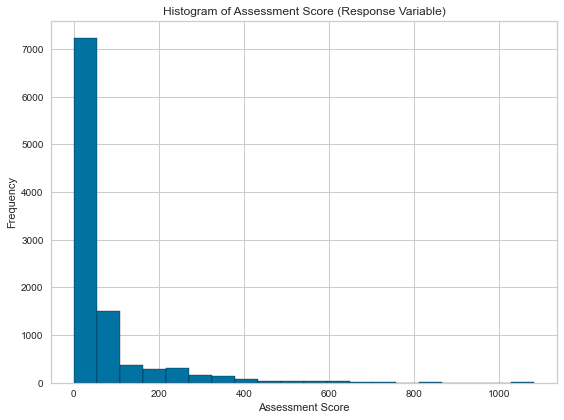

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Histogram of Assessment Score (Response Variable)')
ax.set_xlabel('Assessment Score')
ax.set_ylabel('Frequency')
ax.hist(pepsico_data['Assessment Score'], edgecolor='black', bins=20)
plt.tight_layout()

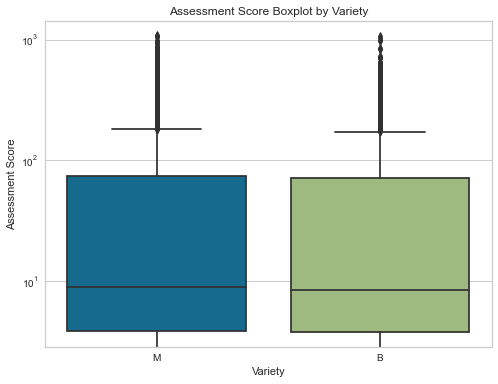

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Assessment Score Boxplot by Variety')
ax = sns.boxplot(x='Variety', y='Assessment Score', data=pepsico_data)
ax.set_yscale("log")

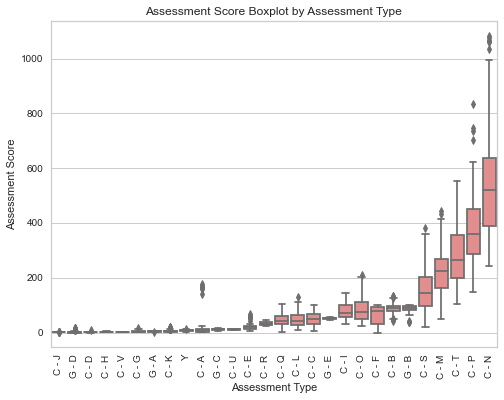

In [46]:
def boxplot_sorted(df, by, column):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Assessment Score Boxplot by Assessment Type')
    ax = sns.boxplot(data=df2[meds.index], color='lightcoral')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('Assessment Type')
    ax.set_ylabel('Assessment Score')

boxplot_sorted(pepsico_data, by=["Assessment Type"], column="Assessment Score")

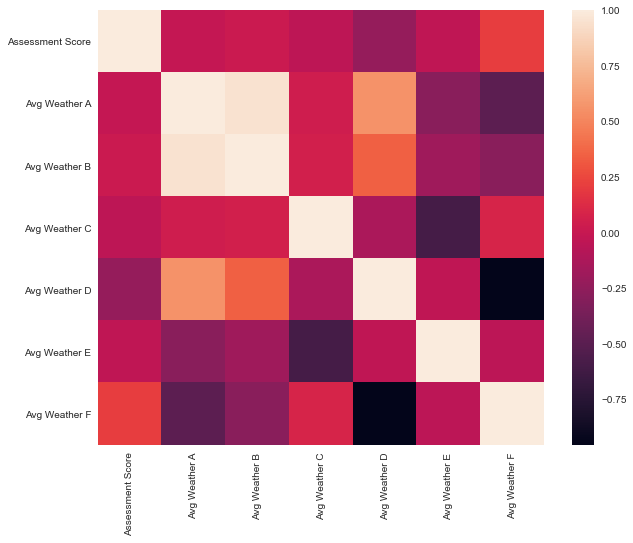

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
corr = pepsico_data[weather_vars].corr()
ax = sns.heatmap(corr)

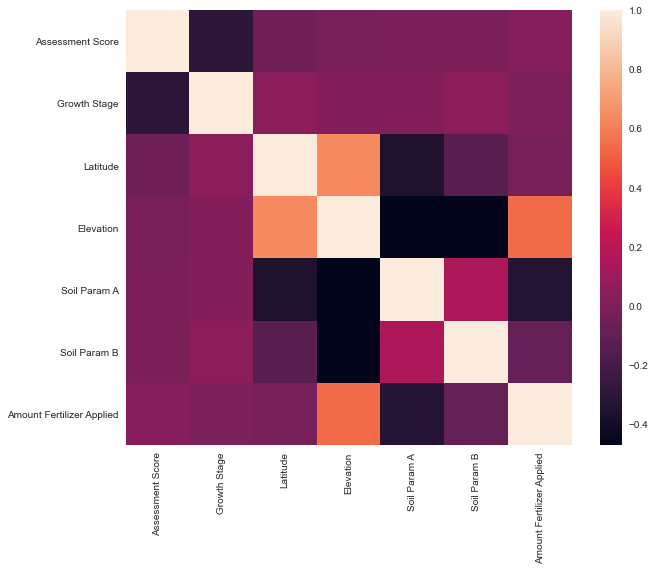

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
corr = pepsico_data[numerical_vars].corr()
ax = sns.heatmap(corr)

In [171]:
# MODEL 1: BASELINE MODEL

# Fit a linear regression model on the subdivided training data
lreg = LinearRegression(fit_intercept=False)
lreg.fit(x_train, y_train)
   
# Make predictions and calculate R^2 on the training and validation set
y_train_pred = lreg.predict(x_train)
y_val_pred = lreg.predict(x_val)
mse_train = r2_score(y_train, y_train_pred)
mse_val = r2_score(y_val, y_val_pred)

# Print out the train and val R^2 for this model
print(f'The R^2 on the training set for the baseline multiple linear regression model is: {mse_train:.4f}')
print(f'The R^2 on the validation set for the baseline multiple linear regression model is: {mse_val:.4f}')

The R^2 on the training set for the baseline multiple linear regression model is: 0.8521
The R^2 on the validation set for the baseline multiple linear regression model is: 0.8340


In [178]:
print(np.argsort(lreg.coef_))
print(x_train.columns[33])

[39 35 36 23 21 38 34 41 24 17 20 18 14 31 11  8  1 10  7  9  0  5  2  4
  3 40  6 30 25 16 22 19 37 28 15 32 26 33 29 27 12 13]
Assessment Type_C - T


In [179]:
# MODEL 2: MODEL WITH INTERACTIONS

# Add interaction between weather variables A and B
x_train['Avg_Weather_AB'] = x_train['Avg Weather A']*x_train['Avg Weather B']
x_val['Avg_Weather_AB'] = x_val['Avg Weather A']*x_val['Avg Weather B']
x_train['Avg_Weather_DF'] = x_train['Avg Weather D']*x_train['Avg Weather F']
x_val['Avg_Weather_DF'] = x_val['Avg Weather D']*x_val['Avg Weather F']
x_train['Latitude_Elevation'] = x_train['Latitude']*x_train['Elevation']
x_val['Latitude_Elevation'] = x_val['Latitude']*x_val['Elevation']
x_train['Fertilizer_Elevation'] = x_train['Amount Fertilizer Applied']*x_train['Elevation']
x_val['Fertilizer_Elevation'] = x_val['Amount Fertilizer Applied']*x_val['Elevation']
x_train['SoilA_Elevation'] = x_train['Soil Param A']*x_train['Elevation']
x_val['SoilA_Elevation'] = x_val['Soil Param A']*x_val['Elevation']
x_train['SoilB_Elevation'] = x_train['Soil Param B']*x_train['Elevation']
x_val['SoilB_Elevation'] = x_val['Soil Param B']*x_val['Elevation']

# Fit a linear regression model on the subdivided training data
lreg = LinearRegression(fit_intercept=False)
lreg.fit(x_train, y_train)
   
# Make predictions and calculate R^2 on the training and validation set
y_train_pred = lreg.predict(x_train)
y_val_pred = lreg.predict(x_val)
mse_train = r2_score(y_train, y_train_pred)
mse_val = r2_score(y_val, y_val_pred)

# Calculate the train and val residuals for the model
train_resid = y_train - y_train_pred
val_resid = y_val - y_val_pred

# Print out the train and val MSE for this model
print(f'The R^2 on the training set for the MLR model with weather interactions is: {mse_train:.4f}')
print(f'The R^2 on the validation set for the MLR model with weather interactions is: {mse_val:.4f}')

The R^2 on the training set for the MLR model with weather interactions is: 0.8534
The R^2 on the validation set for the MLR model with weather interactions is: 0.8357


<ipython-input-179-0eeb86801389>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['Avg_Weather_AB'] = x_train['Avg Weather A']*x_train['Avg Weather B']
<ipython-input-179-0eeb86801389>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['Avg_Weather_AB'] = x_val['Avg Weather A']*x_val['Avg Weather B']
<ipython-input-179-0eeb86801389>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [180]:
print(np.argsort(lreg.coef_))

[ 9 23 21 39 35 36 24 41 38 34 11 20 17  8 18  1 14 42  2 10  3  5 47 45
 44 46  0  4 43  7 31  6 30 25 40 16 22 19 28 37 15 32 26 33 29 27 12 13]


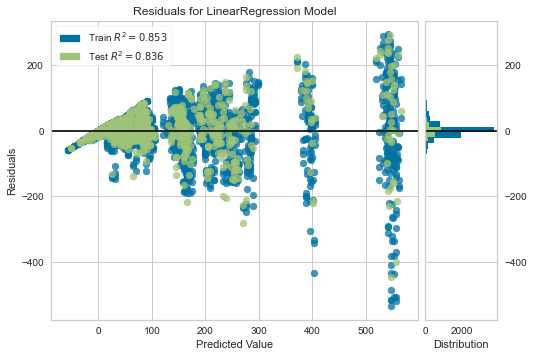

In [181]:
# Instantiate the linear model and visualizer
model = LinearRegression(fit_intercept=False)
visualizer = ResidualsPlot(model, hist=True, qqplot=False)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_val, y_val)    # Evaluate the model on the validation data
visualizer.show()                 # Finalize and render the figure

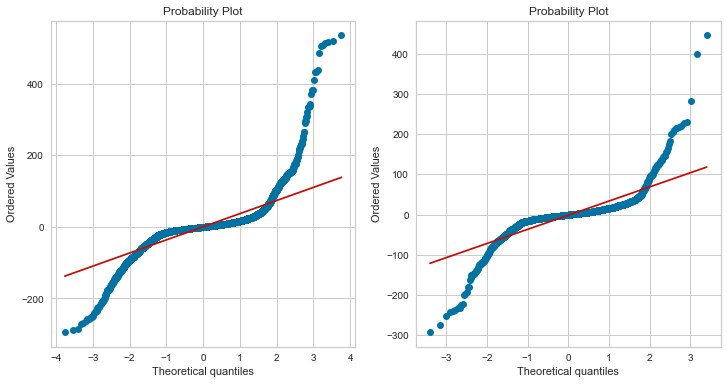

In [182]:
# Before transformation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
prob = stats.probplot(train_resid, dist=stats.norm, plot=ax1)
prob = stats.probplot(val_resid, dist=stats.norm, plot=ax2)

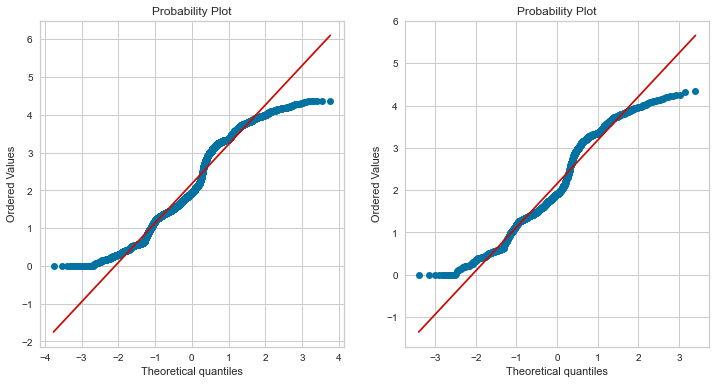

In [183]:
# After Yeo-Johnson transformation
y_train_transform, lmbda1 = stats.yeojohnson(y_train)
y_val_transform = stats.yeojohnson(y_val, lmbda=lmbda1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
prob = stats.probplot(y_train_transform, dist=stats.norm, plot=ax1)
prob = stats.probplot(y_val_transform, dist=stats.norm, plot=ax2)

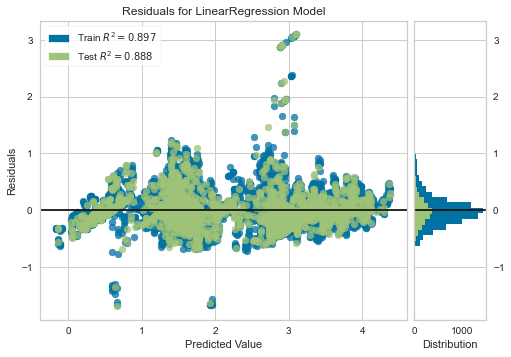

In [184]:
# Instantiate the linear model and visualizer
model2 = LinearRegression(fit_intercept=False)
visualizer2 = ResidualsPlot(model2, hist=True, qqplot=False)

visualizer2.fit(x_train, y_train_transform)  # Fit the training data to the visualizer
visualizer2.score(x_val, y_val_transform)    # Evaluate the model on the validation data
visualizer2.show()                           # Finalize and render the figure

Text(0, 0.5, 'Yeo-Johnson log-likelihood')

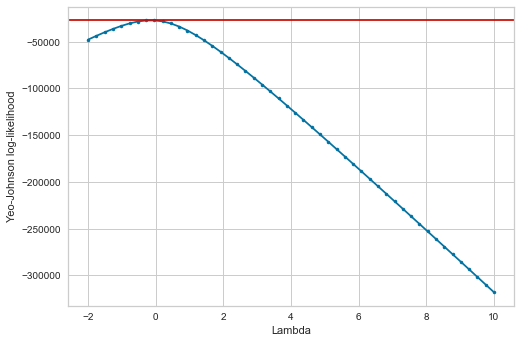

In [185]:
lmbdas = np.linspace(-2, 10)
llf = np.zeros(lmbdas.shape, dtype=float)
for ii, lmbda in enumerate(lmbdas):
    llf[ii] = stats.yeojohnson_llf(lmbda, y_train)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lmbdas, llf, 'b.-')
ax.axhline(stats.yeojohnson_llf(lmbda1, y_train), color='r')
ax.set_xlabel('Lambda')
ax.set_ylabel('Yeo-Johnson log-likelihood')

In [186]:
print(lmbda1)

-0.14665675554034047


In [187]:
# MODEL 3: MODEL WITH TRANSFORMED RESPONSE

# Fit a linear regression model on the transformed training response data
lreg = LinearRegression(fit_intercept=False)
lreg.fit(x_train, y_train_transform)
   
# Make predictions and calculate R^2 on the training and validation set
y_train_pred = lreg.predict(x_train)
y_val_pred = lreg.predict(x_val)
y_train_pred_pos = [x if x >= 0 else 0 for x in y_train_pred]
y_val_pred_pos = [x if x >= 0 else 0 for x in y_val_pred]
mse_train = r2_score(y_train_transform, y_train_pred_pos)
mse_val = r2_score(y_val_transform, y_val_pred_pos)

# Print out the train and val R^2 for this model
print(f'The R^2 on the training set for the MLR model with the transformed response is: {mse_train:.4f}')
print(f'The R^2 on the validation set for the MLR model with the transformed response is: {mse_val:.4f}')

The R^2 on the training set for the MLR model with the transformed response is: 0.8967
The R^2 on the validation set for the MLR model with the transformed response is: 0.8886


In [167]:
x_train.columns[2]

'Elevation'

In [152]:
print(lreg.coef_[32])

0.8901802446608298


In [188]:
print(np.argsort(lreg.coef_))

[12 13 23 17 39 21 35 20 36 24 14 41 38  9 34 18 42  3 11  0 44 47 45 46
  5 43  4 10  2  1  8  6 31 25 16 30 40 19  7 28 22 15 37 32 33 29 26 27]


## Decision Tree Stuff

In [189]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

pepsico_data = pd.read_excel('wrangled-pepsico-data.xlsx')

# Generate binary values using get_dummies on Variety and Assessment Type
wrangled_df = pd.get_dummies(pepsico_data, columns=["Variety", "Assessment Type"])

# Drop all non-predictor/response columns
wrangled_df.drop(["ID", "Site ID", "Assessment Date (mm/dd/year)", "Sowing Date"], axis=1, inplace=True)

# Drop all NaN values
wrangled_df = wrangled_df.dropna()

# Split the data into X and y
X = wrangled_df.drop("Assessment Score", axis=1)
y = wrangled_df['Assessment Score']

# Split the train data into train and validation sets with 80% of the data as train
x_train, x_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=109)

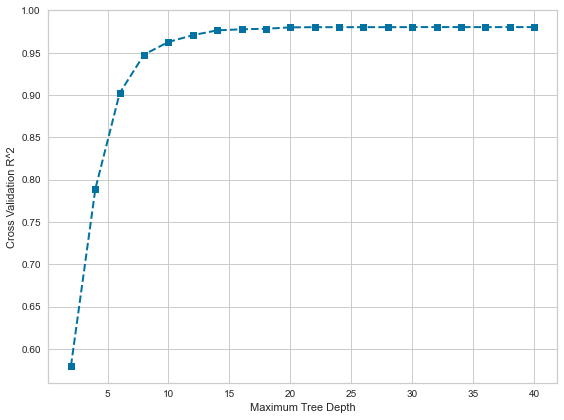

In [190]:
# Create a list of tree depths (hyperparameter for Decision Tree)
tree_depths = np.linspace(2,40,20)

# Initialize list for the test R^2 values
tree_r2_list = []

# Iterate over the values of alpha
for depth in tree_depths:
    
    # Initialize a dtree model
    dtree = DecisionTreeRegressor(max_depth=depth)
    
    # Perform cross-validation on the train data with k=10 and get the predicted values
    cross_val_predicted = cross_val_predict(dtree, x_train, y_train, cv=10)
    
    # Calculate the R^2 on the cross-validation predicted values and append to list
    r2 = r2_score(y_train, cross_val_predicted)
    tree_r2_list.append(r2)
    
# Plot the validation R^2 as a function of tree depth
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(tree_depths, tree_r2_list, 's--', linewidth=2)
ax.set_xlabel('Maximum Tree Depth')
ax.set_ylabel('Cross Validation R^2')
#ax.set_xscale('log')
plt.tight_layout()

# Extract index of alpha value with lowest AAPE
best_depth = tree_depths[np.argmax(tree_r2_list)]

In [191]:
# Fit a dtree with this max_depth
best_dtree = DecisionTreeRegressor(max_depth=best_depth)
best_dtree.fit(x_train, y_train)

# Make predictions and calculate R^2 on the test set
y_train_pred = best_dtree.predict(x_train)
y_val_pred = best_dtree.predict(x_val)
r2_train_dtree = r2_score(y_train, y_train_pred)
r2_val_dtree = r2_score(y_val, y_val_pred)

# Print out the train and test R^2 for this model
print(f'The R^2 on the training set for the best dtree regression model is: {r2_train_dtree:.4f}')
print(f'The R^2 on the validation set for the best dtree regression model is: {r2_val_dtree:.4f}')

The R^2 on the training set for the best dtree regression model is: 0.9900
The R^2 on the validation set for the best dtree regression model is: 0.9810


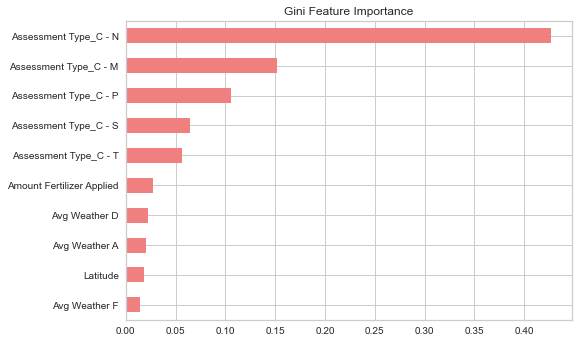

In [192]:
#pd.Series(best_dtree.feature_importances_,index=list(x_train)).sort_values().plot(kind="barh")
pd.Series(best_dtree.feature_importances_,index=list(x_train)).sort_values().tail(10).plot(kind="barh", color='lightcoral', title='Gini Feature Importance')

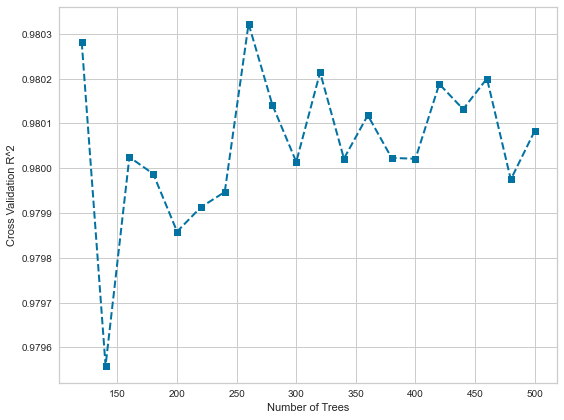

In [106]:
# Create a list of number of trees (hyperparameter for Random Forest)
forest_estimators = np.linspace(120,500,20)

# Initialize list for the test R^2 values
forest_r2_list = []

# Iterate over the number of trees
for n_estimators in forest_estimators:
    
    # Initialize a rforest model
    rforest = RandomForestRegressor(n_estimators=int(n_estimators))
    
    # Perform cross-validation on the train data with k=10 and get the predicted values
    cross_val_predicted = cross_val_predict(rforest, x_train, y_train, cv=10)
    
    # Calculate the R^2 on the cross-validation predicted values and append to list
    r2 = r2_score(y_train, cross_val_predicted)
    forest_r2_list.append(r2)
    
# Plot the validation R^2 as a function of num estimators
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(forest_estimators, forest_r2_list, 's--', linewidth=2)
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Cross Validation R^2')
#ax.set_xscale('log')
plt.tight_layout()

# Extract index of alpha value with lowest AAPE
best_num_trees = forest_estimators[np.argmax(forest_r2_list)]

In [107]:
print(best_num_trees)

260.0


In [111]:
# Fit a rforest with this number of trees
best_rforest = RandomForestRegressor(n_estimators=int(best_num_trees), max_depth=best_depth)
best_rforest.fit(x_train, y_train)

# Make predictions and calculate R^2 on the test set
y_train_pred = best_rforest.predict(x_train)
y_val_pred = best_rforest.predict(x_val)
r2_train_dtree = r2_score(y_train, y_train_pred)
r2_val_dtree = r2_score(y_val, y_val_pred)

# Print out the train and test R^2 for this model
print(f'The R^2 on the training set for the best rforest regression model is: {r2_train_dtree:.4f}')
print(f'The R^2 on the validation set for the best rforest regression model is: {r2_val_dtree:.4f}')

The R^2 on the training set for the best rforest regression model is: 0.9899
The R^2 on the validation set for the best rforest regression model is: 0.9815


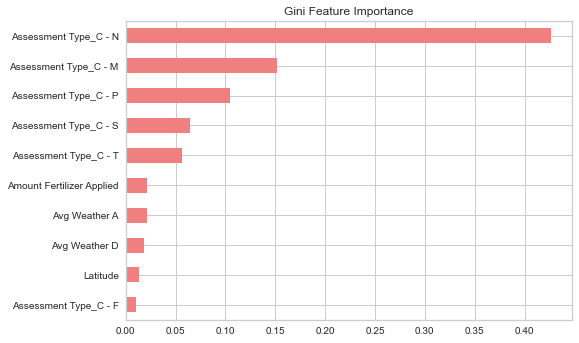

In [119]:
pd.Series(best_rforest.feature_importances_,index=list(x_train)).sort_values().tail(10).plot(kind="barh", color='lightcoral', title='Gini Feature Importance')